baichuan-7B 是百川智能开发的一个强大的中文基座模型，然后它本身并不具备对话能力。为了让它能够像 ChatGPT 一样进行对话，我们需要进行对话风格的微调。本项目就是一个简单的尝试，通过一万多条对话数据来使 baichuan-7B 拥有基础的对话能力。

项目Github地址：https://github.com/beyondguo/LLM-Tuning

# 1. 数据准备
我们采用 HC3(Human-ChatGPT Comparison Corpus) 数据集，来作为对话微调样本，见：

HC3 项目：https://github.com/Hello-SimpleAI/chatgpt-comparison-detection
HC3 数据集：https://huggingface.co/Hello-SimpleAI
HC3 数据集包含了多个不同领域的QA问答对，且每个问题都至少包含一个人类和一个ChatGPT的回答，因此十分适合用于 ChatBot 的微调，MosaicML 的mpt-7b-chat模型和 UC Berkeley 的 Koala-13B模型都使用了 HC3 数据集进行开发。

下面是 HC3-Chinese 数据集的一个截面：

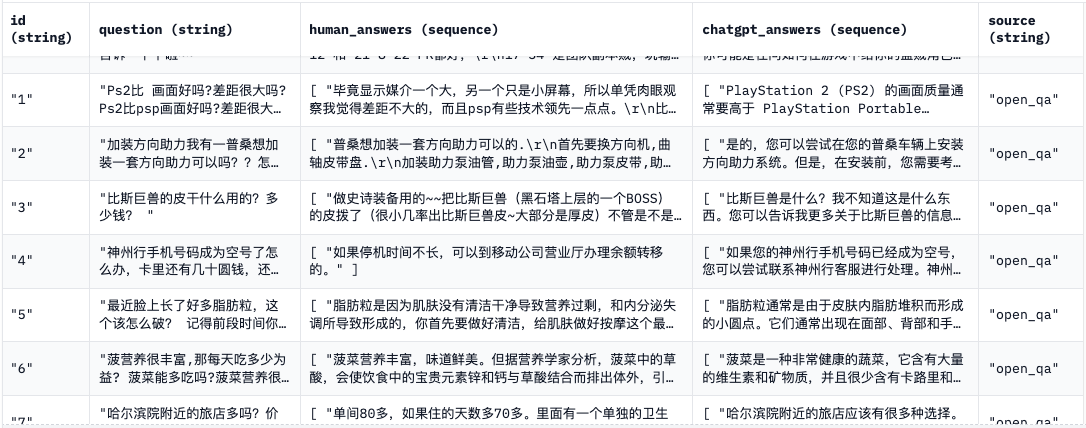


具体数据处理的代码，见GitHub仓库中的 hc3_data_prepare.py.

最终得到 hc3_chatgpt_zh_specific_qa.json 文件。

# 2. 使用 LoRA 微调
执行 sh tokenize.sh，进行分词:

In [ ]:
CUDA_VISIBLE_DEVICES=0 python tokenize_dataset_rows.py \
    --model_checkpoint baichuan-inc/baichuan-7B \
    --input_file hc3_chatgpt_zh_specific_qa.json \
    --prompt_key q \
    --target_key a \
    --save_name hc3_chatgpt_zh_specific_qa_baichuan-7B \
    --max_seq_length 2000 \
    --skip_overlength False

执行 sh train.sh，进行训练：

In [ ]:
CUDA_VISIBLE_DEVICES=0,1,2,3 python baichuan_lora_tuning.py \
    --tokenized_dataset hc3_chatgpt_zh_specific_qa_baichuan-7B \
    --lora_rank 4 \
    --per_device_train_batch_size 16 \
    --gradient_accumulation_steps 1 \
    --num_train_epochs 2 \
    --save_steps 200 \
    --save_total_limit 2 \
    --learning_rate 1e-4 \
    --fp16 \
    --remove_unused_columns false \
    --logging_steps 50 \
    --output_dir weights/hc3_chatgpt_zh_specific_qa_baichuan-7B

# 3. 得到 ChatBaichuan，可以对话啦！

In [ ]:
# 看看训练之后baichuan是否具备了Chat能力：
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
from transformers import TextStreamer

tokenizer = AutoTokenizer.from_pretrained("baichuan-inc/baichuan-7B", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("baichuan-inc/baichuan-7B", device_map="auto", trust_remote_code=True)
# load LoRA:
model = PeftModel.from_pretrained(model, "weights/hc3_chatgpt_zh_specific_qa_baichuan-7B")

def chat(text):
    streamer = TextStreamer(tokenizer,skip_prompt=True,skip_special_tokens=True)
    inputs = tokenizer("问："+text+"答：", return_tensors='pt') # 这里添加 "问：","答："，是为了跟我构造的训练数据对应，从而更好地引导模型进行回答
    inputs = inputs.to('cuda:0')
    output = model.generate(**inputs, max_new_tokens=1024,repetition_penalty=1.1, streamer=streamer)


# 下面是效果：
**输入**：哎，最近晚上睡不着！

**原始 baichuan-7B**：你是不是想多了？
1、我有一个朋友。他喜欢一个女生很久了，但是一直没有勇气表白。有一次他们出去玩的时候，那个男生不小心把脚给扭到了。然后他就对那位女生说:“你看我的脚都肿成这样子了，还怎么去见你啊?”结果没想到的是，这位女生竟然回答道:“没事的，没关系!2、今天在街上看到一对情侣，女的长得挺漂亮，男的大腹便便，肚子鼓的老高老高的，走路一摇一摆的，看着很不协调。于是我就走过去拍了一下他的肩膀说道:哥们儿，这身材真好呀，有福气哦~谁知那货回头看了看我说到:兄弟别误会，这是我老婆...3、昨天和女朋友吵架，她摔门而出去了外面住酒店。早上起来发现手机上有条短信“对不起，您昨晚消费0元”当时就怒了，什么人啊，查岗也查这么清楚，立马打电话给她质问，电话通了传来一个温柔的声音“对不起，我们是移动公司，刚才查询您的账单时看到了您的男朋友在外面开房，所以特地发个信息提醒一下。......
ChatBaichun-HC3: 很抱歉听到你感到困扰。睡眠问题是很常见的，并且可能对你的生活造成很大的影响。如果你正在经历失眠的困扰，这里有一些建议可以帮助你改善睡眠质量：尝试睡前放松：在睡觉前花一些时间进行冥想、呼吸练习或其他有助于放松的活动。保持卧室安静舒适：尽量避免噪音和光线干扰，并确保床垫软硬适中。保证充足的睡眠时间：每天至少要保证7-8小时的睡眠时间。如果无法达到这个目标，你可以考虑调整自己的作息习惯来增加睡眠时间。寻找原因：有时候，睡眠问题的出现可能是由于某些因素导致的，例如压力过大、身体不适或者饮食不规律等。因此，不妨找出导致睡眠问题的根本原因，然后采取适当的措施加以解决。希望这些建议能对你有所帮助。